Training using Google Colab. So need to upload the dataset to /content
Changing the Runtime to be GPU allowing for using cuda


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# read the dataset
df = pd.read_csv('/content/preprocessed_data_correct_with_others.csv')
print(df.head())

           category                                              title  \
0  Autos & Vehicles     porsche turbo v bentley continental fifth gear   
1  Autos & Vehicles                                    make racing car   
2  Autos & Vehicles               gta review bentley continental gt hd   
3  Autos & Vehicles  mitsubishi eclipse gst car audio system instal...   
4  Autos & Vehicles           make charging motorbike battery easy diy   

                                         description  
0  vicki tiff classic shootout porsche turbo cabr...  
1  building special racing car home koda maxi ste...  
2               gta review bentley continental gt hd  
3  bro got tired honda traded bad as eclipse need...  
4  note disconnected earth first reconnect last m...  


In [ ]:
# check the number of records for each type
category_counts = df['category'].value_counts()
print(category_counts)

category
Autos & Vehicles    4949
Food & Drink        4215
Pets & Animals      3566
Others              1909
Name: count, dtype: int64


In [ ]:
# do class balancing

from sklearn.utils import resample

df_auto = df[df.category == "Autos & Vehicles"]
df_food = df[df.category == "Food & Drink"]
df_pets = df[df.category == "Pets & Animals"]
df_others = df[df.category == "Others"]

# Oversample the minority classes
df_food_new = resample(df_food, replace=True, n_samples=len(df_auto), random_state=1508)
df_pets_new = resample(df_pets, replace=True, n_samples=len(df_auto), random_state=1508)
df_others_new = resample(df_others, replace=True, n_samples=len(df_auto), random_state=1508)

df_new = pd.concat([df_auto, df_food_new, df_pets_new, df_others_new])
df = df_new

print(df_new.category.value_counts())


category
Autos & Vehicles    4949
Food & Drink        4949
Pets & Animals      4949
Others              4949
Name: count, dtype: int64


In [ ]:
# Tokenize the titles, then vectorize using Word2Vec, also pad the sequence
tokenized_titles = [simple_preprocess(str(title)) for title in df['title']]

title_word2vec_model = Word2Vec(sentences=tokenized_titles, vector_size=100, window=5, min_count=1, workers=4)

words = list(title_word2vec_model.wv.index_to_key)

title_indices = [[title_word2vec_model.wv.key_to_index[word] if word in title_word2vec_model.wv else 0 for word in title] for title in tokenized_titles]

# Convert the indices to PyTorch tensors
title_tensors = [torch.tensor(title) for title in title_indices]

# Pad the sequences
padded_titles = pad_sequence(title_tensors, batch_first=True)

print(padded_titles.shape)

torch.Size([19796, 16])


In [ ]:
# similar for descriptions, tokenize the descriptions, then vectorize using Word2Vec, also pad the sequence
tokenized_descriptions = [simple_preprocess(str(description)) for description in df['description']]
description_word2vec_model = Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)
description_indices = [[description_word2vec_model.wv.key_to_index[word] if word in description_word2vec_model.wv else 0 for word in tokenized_description] for tokenized_description in tokenized_descriptions]

description_tensors = [torch.tensor(indices, dtype=torch.long) for indices in description_indices]
padded_descriptions = pad_sequence(description_tensors, batch_first=True, padding_value=0)

print(padded_descriptions.shape)

torch.Size([19796, 639])


In [ ]:
# Add the '<pad>' token to title vocabulary, since the model architecture requires the index of '<pad>'
pad_vector = np.zeros((1, title_word2vec_model.vector_size))
title_word2vec_model.wv.vectors = np.vstack((pad_vector, title_word2vec_model.wv.vectors))
title_word2vec_model.wv.index_to_key = ['<pad>'] + title_word2vec_model.wv.index_to_key
title_word2vec_model.wv.key_to_index = {word: idx for idx, word in enumerate(title_word2vec_model.wv.index_to_key)}

# get the pad index
TITLE_PAD_IDX = title_word2vec_model.wv.key_to_index['<pad>']

# Add the '<pad>' token to description vocabulary, since the model architecture requires the index of '<pad>'
pad_vector = np.zeros((1, description_word2vec_model.vector_size))
description_word2vec_model.wv.vectors = np.vstack((pad_vector, description_word2vec_model.wv.vectors))
description_word2vec_model.wv.index_to_key = ['<pad>'] + description_word2vec_model.wv.index_to_key
description_word2vec_model.wv.key_to_index = {word: idx for idx, word in enumerate(description_word2vec_model.wv.index_to_key)}

# get the pad index
DESCRIPTION_PAD_IDX = title_word2vec_model.wv.key_to_index['<pad>']

TITLE_VOCAB_SIZE = len(title_word2vec_model.wv) + 1
DESCRIPTION_VOCAB_SIZE = len(description_word2vec_model.wv) + 1

# define parameters for the model
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 4

In [ ]:
# label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['category'])

labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)

print(labels_tensor.shape)

torch.Size([19796])


In [ ]:
# dataset class, used for data loader
class VideoDataset(Dataset):
    def __init__(self, titles, descriptions, labels):
        self.titles = titles
        self.descriptions = descriptions
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title = self.titles[idx]
        description = self.descriptions[idx]
        label = self.labels[idx]
        return title, description, label

In [ ]:
dataset = VideoDataset(padded_titles, padded_descriptions, labels_tensor)

In [ ]:
# get the train and test data loader

# tran test spilt with 0.7-0.3
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

BATCH_SIZE = 32

# Create train and test data loaders
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_data_loader))
print(len(test_data_loader))


434
186


In [ ]:
def train(model, train_data_loader, test_data_loader, optimizer, criterion, device, epochs, save_model=False, model_name=None):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for titles, descriptions, labels in train_data_loader:
            titles = titles.to(device)
            descriptions = descriptions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            predictions = model(titles, descriptions)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total

        # testing
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for titles, descriptions, labels in test_data_loader:
                titles = titles.to(device)
                descriptions = descriptions.to(device)
                labels = labels.to(device)

                predictions = model(titles, descriptions)
                loss = criterion(predictions, labels)
                test_loss += loss.item()
                _, predicted = torch.max(predictions.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_accuracy = 100 * test_correct / test_total

        train_loss = train_loss / len(train_data_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        test_loss = test_loss / len(test_data_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        if save_model:
            torch.save(model.state_dict(), '/content/models/{}_epoch{}'.format(model_name, epoch + 1))

    # After training, plot the training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracies, test_losses, test_accuracies, model



In [ ]:
class DualRNNClassifierDropout(nn.Module):
    def __init__(self, title_vocab_size, description_vocab_size, title_pad_idx, description_pad_idx, embedding_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(DualRNNClassifierDropout, self).__init__()
        self.title_embedding = nn.Embedding(title_vocab_size, embedding_dim, padding_idx=title_pad_idx)
        self.description_embedding = nn.Embedding(description_vocab_size, embedding_dim, padding_idx=description_pad_idx)

        self.title_rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.description_rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, title, description):
        title_embedded = self.dropout(self.title_embedding(title))
        description_embedded = self.dropout(self.description_embedding(description))

        _, (title_hidden, _) = self.title_rnn(title_embedded)
        _, (description_hidden, _) = self.description_rnn(description_embedded)

        title_hidden = title_hidden[-1]
        description_hidden = description_hidden[-1]

        combined = torch.cat((title_hidden, description_hidden), dim=1)
        combined = self.dropout(combined)
        predictions = self.fc(combined)
        return predictions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Epoch 1/40
Train Loss: 1.3114, Train Accuracy: 32.60%
Test Loss: 1.2286, Test Accuracy: 39.86%
Epoch 2/40
Train Loss: 1.1109, Train Accuracy: 46.29%
Test Loss: 1.0957, Test Accuracy: 49.79%
Epoch 3/40
Train Loss: 0.9093, Train Accuracy: 57.55%
Test Loss: 0.9832, Test Accuracy: 55.99%
Epoch 4/40
Train Loss: 0.6811, Train Accuracy: 69.99%
Test Loss: 0.9708, Test Accuracy: 62.92%
Epoch 5/40
Train Loss: 0.4775, Train Accuracy: 80.52%
Test Loss: 0.9196, Test Accuracy: 66.91%
Epoch 6/40
Train Loss: 0.3385, Train Accuracy: 87.27%
Test Loss: 0.9468, Test Accuracy: 70.45%
Epoch 7/40
Train Loss: 0.2210, Train Accuracy: 92.58%
Test Loss: 1.0886, Test Accuracy: 72.02%
Epoch 8/40
Train Loss: 0.1411, Train Accuracy: 95.68%
Test Loss: 0.9736, Test Accuracy: 73.41%
Epoch 9/40
Train Loss: 0.1069, Train Accuracy: 96.84%
Test Loss: 1.1543, Test Accuracy: 74.39%
Epoch 10/40
Train Loss: 0.0706, Train Accuracy: 98.02%
Test Loss: 1.2215, Test Accuracy: 73.82%
Epoch 11/40
Train Loss: 0.0697, Train Accuracy: 9

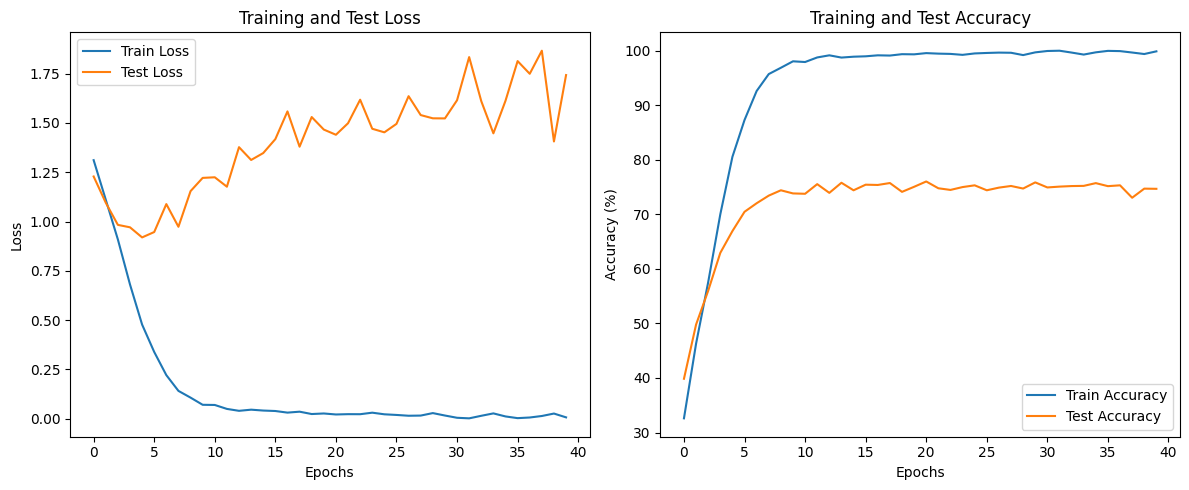

In [ ]:
# both title and description using LSTM, with no dropout 0.2, train-test 0.7-0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualRNNClassifierDropout(
    TITLE_VOCAB_SIZE,
    DESCRIPTION_VOCAB_SIZE,
    TITLE_PAD_IDX,
    DESCRIPTION_PAD_IDX,
    EMBEDDING_DIM,
    HIDDEN_DIM,
    OUTPUT_DIM,
    dropout_rate=0.0
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

N_EPOCHS = 40

model_name = 'model'
train_losses, train_accuracies, test_losses, test_accuracies, model = train(model, train_data_loader, test_data_loader, optimizer, criterion, device, N_EPOCHS, save_model=True, model_name=model_name)
# torch.save(model.state_dict(), '/content/models/model_dropout_and_reg')

Epoch 1/40
Train Loss: 1.3282, Train Accuracy: 31.42%
Test Loss: 1.2310, Test Accuracy: 36.62%
Epoch 2/40
Train Loss: 1.1796, Train Accuracy: 40.10%
Test Loss: 1.1507, Test Accuracy: 42.33%
Epoch 3/40
Train Loss: 1.0642, Train Accuracy: 45.50%
Test Loss: 1.1018, Test Accuracy: 43.07%
Epoch 4/40
Train Loss: 0.9915, Train Accuracy: 48.71%
Test Loss: 1.0862, Test Accuracy: 46.46%
Epoch 5/40
Train Loss: 0.9197, Train Accuracy: 54.12%
Test Loss: 1.0044, Test Accuracy: 54.99%
Epoch 6/40
Train Loss: 0.8021, Train Accuracy: 61.69%
Test Loss: 0.9250, Test Accuracy: 59.12%
Epoch 7/40
Train Loss: 0.6823, Train Accuracy: 67.26%
Test Loss: 0.8739, Test Accuracy: 64.39%
Epoch 8/40
Train Loss: 0.5821, Train Accuracy: 73.55%
Test Loss: 0.8556, Test Accuracy: 66.98%
Epoch 9/40
Train Loss: 0.4958, Train Accuracy: 78.23%
Test Loss: 0.8737, Test Accuracy: 69.09%
Epoch 10/40
Train Loss: 0.4232, Train Accuracy: 82.49%
Test Loss: 0.8205, Test Accuracy: 72.52%
Epoch 11/40
Train Loss: 0.3546, Train Accuracy: 8

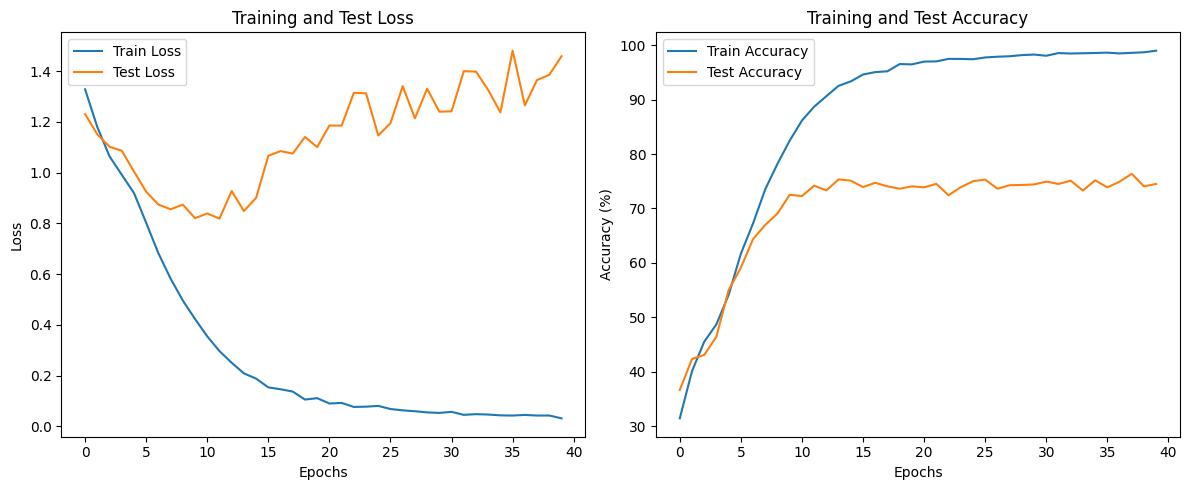

In [ ]:
# both title and description using LSTM, with dropout 0.2, train-test 0.7-0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualRNNClassifierDropout(
    TITLE_VOCAB_SIZE,
    DESCRIPTION_VOCAB_SIZE,
    TITLE_PAD_IDX,
    DESCRIPTION_PAD_IDX,
    EMBEDDING_DIM,
    HIDDEN_DIM,
    OUTPUT_DIM
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

N_EPOCHS = 40

model_name = 'model_dropout'
train_losses, train_accuracies, test_losses, test_accuracies, model = train(model, train_data_loader, test_data_loader, optimizer, criterion, device, N_EPOCHS, save_model=True, model_name=model_name)

Epoch 1/40
Train Loss: 1.3563, Train Accuracy: 30.05%
Test Loss: 1.2778, Test Accuracy: 36.34%
Epoch 2/40
Train Loss: 1.1953, Train Accuracy: 40.53%
Test Loss: 1.1909, Test Accuracy: 40.51%
Epoch 3/40
Train Loss: 1.0773, Train Accuracy: 47.03%
Test Loss: 1.0985, Test Accuracy: 48.78%
Epoch 4/40
Train Loss: 0.9659, Train Accuracy: 54.12%
Test Loss: 1.0327, Test Accuracy: 55.26%
Epoch 5/40
Train Loss: 0.8558, Train Accuracy: 60.94%
Test Loss: 0.9627, Test Accuracy: 59.47%
Epoch 6/40
Train Loss: 0.7342, Train Accuracy: 68.20%
Test Loss: 0.9280, Test Accuracy: 62.72%
Epoch 7/40
Train Loss: 0.6226, Train Accuracy: 74.37%
Test Loss: 0.8851, Test Accuracy: 66.05%
Epoch 8/40
Train Loss: 0.5181, Train Accuracy: 79.77%
Test Loss: 0.8613, Test Accuracy: 68.56%
Epoch 9/40
Train Loss: 0.4289, Train Accuracy: 83.81%
Test Loss: 0.8503, Test Accuracy: 70.53%
Epoch 10/40
Train Loss: 0.3632, Train Accuracy: 86.63%
Test Loss: 0.8809, Test Accuracy: 72.54%
Epoch 11/40
Train Loss: 0.3192, Train Accuracy: 8

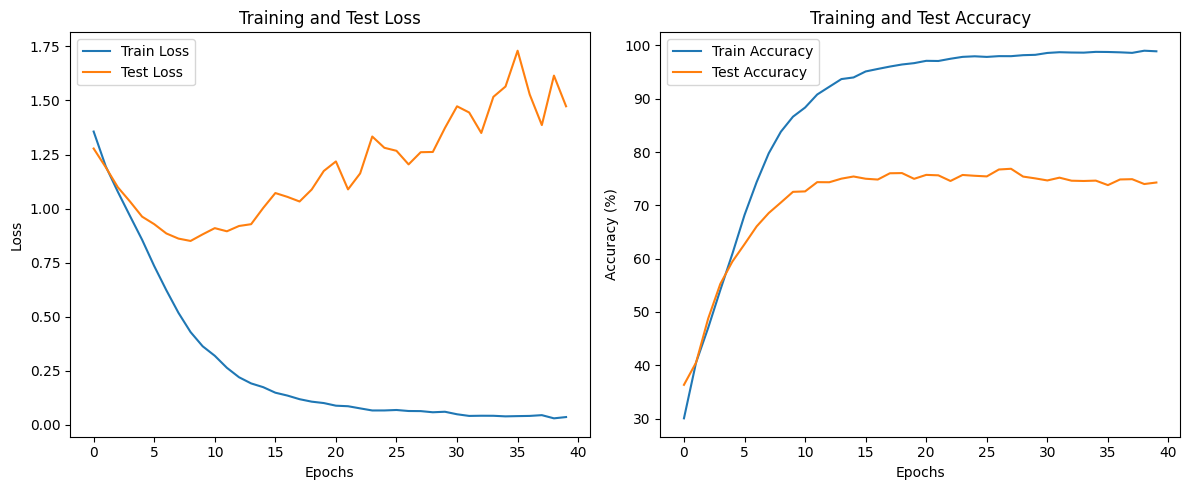

In [ ]:
# both title and description using LSTM, with dropout 0.2 and l2 regularization 1e-5, train-test 0.7-0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualRNNClassifierDropout(
    TITLE_VOCAB_SIZE,
    DESCRIPTION_VOCAB_SIZE,
    TITLE_PAD_IDX,
    DESCRIPTION_PAD_IDX,
    EMBEDDING_DIM,
    HIDDEN_DIM,
    OUTPUT_DIM
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

N_EPOCHS = 40

model_name = 'model_dropout_and_reg'
train_losses, train_accuracies, test_losses, test_accuracies, model = train(model, train_data_loader, test_data_loader, optimizer, criterion, device, N_EPOCHS, save_model=True, model_name=model_name)
# torch.save(model.state_dict(), '/content/models/model_dropout_and_reg')

In [ ]:
# select the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualRNNClassifierDropout(
    TITLE_VOCAB_SIZE,
    DESCRIPTION_VOCAB_SIZE,
    TITLE_PAD_IDX,
    DESCRIPTION_PAD_IDX,
    EMBEDDING_DIM,
    HIDDEN_DIM,
    OUTPUT_DIM,
)
model.to(device)

model.load_state_dict(torch.load('/content/models/model_dropout_and_reg_epoch28'))

<All keys matched successfully>

In [ ]:
# evaluate the best model
model.eval()

with torch.no_grad():
    for titles, descriptions, labels in test_data_loader:
        titles, descriptions = titles.to(device), descriptions.to(device)

        outputs = model(titles, descriptions)

        _, predicted_classes = torch.max(outputs, 1)
        predicted_labels = label_encoder.inverse_transform(predicted_classes.cpu().numpy())

        true_labels = label_encoder.inverse_transform(labels.cpu().numpy())

        print("Predicted labels: ", predicted_labels)
        print("True labels: ", true_labels)

        accuracy = (predicted_labels == true_labels).sum() / len(true_labels)
        print('Accuracy: {}'.format(accuracy))

        break


Predicted labels:  ['Pets & Animals' 'Food & Drink' 'Others' 'Autos & Vehicles'
 'Autos & Vehicles' 'Autos & Vehicles' 'Pets & Animals' 'Others'
 'Autos & Vehicles' 'Autos & Vehicles' 'Autos & Vehicles' 'Others'
 'Food & Drink' 'Pets & Animals' 'Pets & Animals' 'Others'
 'Pets & Animals' 'Pets & Animals' 'Autos & Vehicles' 'Autos & Vehicles'
 'Pets & Animals' 'Others' 'Food & Drink' 'Autos & Vehicles'
 'Autos & Vehicles' 'Food & Drink' 'Pets & Animals' 'Pets & Animals'
 'Food & Drink' 'Autos & Vehicles' 'Food & Drink' 'Food & Drink']
True labels:  ['Pets & Animals' 'Food & Drink' 'Autos & Vehicles' 'Autos & Vehicles'
 'Autos & Vehicles' 'Others' 'Pets & Animals' 'Autos & Vehicles'
 'Autos & Vehicles' 'Food & Drink' 'Autos & Vehicles' 'Others'
 'Food & Drink' 'Autos & Vehicles' 'Pets & Animals' 'Others'
 'Pets & Animals' 'Autos & Vehicles' 'Autos & Vehicles' 'Autos & Vehicles'
 'Pets & Animals' 'Others' 'Food & Drink' 'Food & Drink'
 'Autos & Vehicles' 'Food & Drink' 'Food & Drink' 'Pet

In [ ]:
# demo a single data point that contains label, title, description, see how the model makes the prediction
def demo_data_point(label, title, description):
  tokenized_titles = [simple_preprocess(str(title))]
  title_indices = [[title_word2vec_model.wv.key_to_index[word] if word in title_word2vec_model.wv else 0 for word in title] for title in tokenized_titles]
  title_tensors = [torch.tensor(title) for title in title_indices]
  padded_titles = pad_sequence(title_tensors, batch_first=True)

  tokenized_descriptions = [simple_preprocess(str(description))]
  description_indices = [[description_word2vec_model.wv.key_to_index[word] if word in description_word2vec_model.wv else 0 for word in tokenized_description] for tokenized_description in tokenized_descriptions]
  description_tensors = [torch.tensor(indices, dtype=torch.long) for indices in description_indices]
  padded_descriptions = pad_sequence(description_tensors, batch_first=True, padding_value=0)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  padded_titles = padded_titles.to(device)
  padded_descriptions = padded_descriptions.to(device)
  model.to(device)

  model.eval()

  with torch.no_grad():
      prediction = model(padded_titles, padded_descriptions)
      predicted_index = torch.argmax(prediction, dim=1).item()

  predicted_class = label_encoder.inverse_transform([predicted_index])

  print("The predicted class is: {}".format(predicted_class[0]))
  print("The true class is: {}".format(label))

In [ ]:
df = pd.read_csv('/content/preprocessed_data_correct_with_others.csv')
df.iloc[5]

category                                       Autos & Vehicles
title                           amazing marble race season part
description    welcome amazing marble race marble battle dollar
Name: 5, dtype: object

In [ ]:
demo_data_point(df.iloc[5][0], df.iloc[5][1], df.iloc[5][2])

The predicted class is: Autos & Vehicles
The true class is: Autos & Vehicles


In [ ]:
demo_data_point('Others', 'play with friends outside do sports', 'summer view warm')

The predicted class is: Autos & Vehicles
The true class is: Others


In [ ]:
demo_data_point('Autos & Vehicles', 'fix engine for your car', 'easy fix')

The predicted class is: Autos & Vehicles
The true class is: Autos & Vehicles


In [ ]:
demo_data_point('Pets & Animals', 'get your new pet cat or dog', 'get your new pet')

The predicted class is: Autos & Vehicles
The true class is: Pets & Animals
